In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00
time: 328 µs (started: 2024-01-15 18:09:50 +00:00)


In [3]:
import glob, os
import random
import shutil
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
path="drive/MyDrive/imagensOriginais/"
imagens_originais= glob.glob(os.path.join(path, '*.jpg'))

time: 1.1 s (started: 2024-01-15 18:09:54 +00:00)


In [4]:
def dataset(file_list,size=(224,224)):
	imagens = []
	for i, file in enumerate(imagens_originais):
		imagem = io.imread(file)
		imagem = transform.resize(imagem, size, mode='constant')
		imagens.append(imagem)

	labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

	return np.array(imagens), np.array(labels)

time: 887 µs (started: 2024-01-15 18:09:58 +00:00)


In [5]:
imagens,labels=dataset(imagens_originais)

time: 40.1 s (started: 2024-01-15 18:10:02 +00:00)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(imagens, labels, test_size = 0.20, random_state = 40)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 40)

time: 463 ms (started: 2024-01-15 18:10:42 +00:00)


In [7]:
EPOCHS = 60
BATCH_SIZE = 16

time: 488 µs (started: 2024-01-15 18:10:42 +00:00)


In [8]:
train_generator = ImageDataGenerator(
                                      shear_range=30,
                                      rotation_range=20,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                  ).flow(X_train, Y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator(
                                      shear_range=30,
                                      rotation_range=20,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                  ).flow(X_validation, Y_validation, batch_size=BATCH_SIZE)

time: 137 ms (started: 2024-01-15 18:10:42 +00:00)


In [9]:
def create_model():
  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Congela todas as camadas
  for layer in base_model.layers:
    layer.trainable = False

  # Descongela as sete últimas camadas convolucionais
  for layer in base_model.layers[-7:]:
    layer.trainable = True

  x = base_model.output
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  predictions = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model(inputs=base_model.input, outputs=predictions)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])

  return model

time: 1.01 ms (started: 2024-01-15 18:10:53 +00:00)


In [10]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "ResnetV2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

time: 505 µs (started: 2024-01-15 18:11:15 +00:00)


In [11]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq="epoch")

time: 759 µs (started: 2024-01-15 18:11:23 +00:00)


In [12]:
model = create_model()
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

94668760/94668760 [==============================] - 0s 0us/step
time: 4.36 s (started: 2024-01-15 18:11:26 +00:00)


In [13]:
steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

time: 639 µs (started: 2024-01-15 18:11:35 +00:00)


In [14]:
history = model.fit(train_generator,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   callbacks=[cp_callback],
                   validation_data=validation_generator,
                   validation_steps=validation_steps,
                   shuffle=True,
                   verbose=2)

Epoch 1/60

Epoch 1: saving model to ResnetV2/cp-0001.ckpt
30/30 - 26s - loss: 0.8901 - acc: 0.7228 - val_loss: 0.4175 - val_acc: 0.8625 - 26s/epoch - 883ms/step
Epoch 2/60

Epoch 2: saving model to ResnetV2/cp-0002.ckpt
30/30 - 12s - loss: 0.5861 - acc: 0.8081 - val_loss: 0.5407 - val_acc: 0.8000 - 12s/epoch - 388ms/step
Epoch 3/60

Epoch 3: saving model to ResnetV2/cp-0003.ckpt
30/30 - 10s - loss: 0.3028 - acc: 0.8742 - val_loss: 0.1890 - val_acc: 0.9375 - 10s/epoch - 331ms/step
Epoch 4/60

Epoch 4: saving model to ResnetV2/cp-0004.ckpt
30/30 - 9s - loss: 0.3565 - acc: 0.8742 - val_loss: 0.2228 - val_acc: 0.9125 - 9s/epoch - 292ms/step
Epoch 5/60

Epoch 5: saving model to ResnetV2/cp-0005.ckpt
30/30 - 10s - loss: 0.3045 - acc: 0.8806 - val_loss: 0.3780 - val_acc: 0.8500 - 10s/epoch - 346ms/step
Epoch 6/60

Epoch 6: saving model to ResnetV2/cp-0006.ckpt
30/30 - 8s - loss: 0.2239 - acc: 0.9211 - val_loss: 0.2108 - val_acc: 0.9250 - 8s/epoch - 276ms/step
Epoch 7/60

Epoch 7: saving mode

In [34]:
# Especificar o diretório de destino no Google Drive
drive_dir = '/content/drive/MyDrive/ResNet50V2/'

time: 641 µs (started: 2024-01-15 19:12:14 +00:00)


In [35]:
shutil.copytree(checkpoint_dir, drive_dir)

'/content/drive/MyDrive/ResNet50V2/'

time: 7min 31s (started: 2024-01-15 19:12:18 +00:00)


In [17]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points

time: 649 µs (started: 2024-01-15 18:31:56 +00:00)


In [18]:
def imprime_graficos(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  plt.plot(epochs, smooth_curve(acc), 'bo', label='Treinamento acc')
  plt.plot(epochs, smooth_curve(val_acc), 'r-', label='Validação acc')
  plt.legend()
  plt.title('Treinamento and Validação Acc')
  plt.figure()

  plt.plot(epochs, smooth_curve(loss), 'bo', label='Treinamento loss')
  plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validação loss')
  plt.legend()
  plt.title('Treinamento e Validação Loss')
  plt.show()

  print("\n")

time: 729 µs (started: 2024-01-15 18:31:57 +00:00)


In [19]:
def metricas(modelo_metricas, epocas):

  # Obter as previsões do modelo nos dados de teste
  y_pred = modelo_metricas.predict(X_test)

  # Converter as previsões em rótulos binários
  y_pred_binary = (y_pred > 0.5).astype(int)

  # Calcular as métricas de precisão, recall e F1 Score
  classification_rep = classification_report(Y_test, y_pred_binary)
  print("Classification Report:\n", classification_rep)


  #Calcula a matriz de confusão
  cm = confusion_matrix(Y_test, y_pred_binary)
  # Display
  plt.figure(figsize=(4, 4))

  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
  plt.yticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix " + str(epocas) + " épocas")

  plt.show()

  print("\n")

time: 1.01 ms (started: 2024-01-15 18:32:00 +00:00)


In [40]:
shutil.rmtree(VGG16, ignore_errors=False, onerror=None)

NameError: name 'VGG16' is not defined

time: 35.8 ms (started: 2024-01-15 19:26:47 +00:00)


Avaliando modelo com checkpoint ResnetV2/cp-0010.ckpt correspondente a época 10
5/5 [==============================] - 7s 516ms/step - loss: 0.2663 - acc: 0.9021
Restored model, accuracy: 0.9020978808403015
Restored model, loss: 0.2662610709667206

5/5 [==============================] - 1s 81ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        67
           1       0.91      0.91      0.91        76

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143



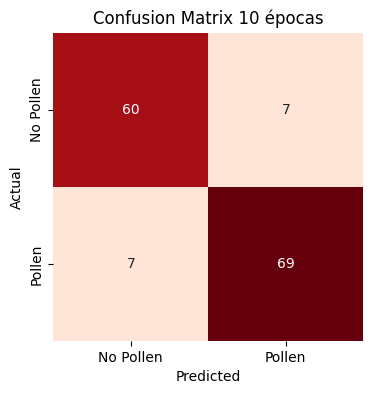



Avaliando modelo com checkpoint ResnetV2/cp-0020.ckpt correspondente a época 20


5/5 [==============================] - 3s 83ms/step - loss: 0.2629 - acc: 0.9021
Restored model, accuracy: 0.9020978808403015
Restored model, loss: 0.26285359263420105

5/5 [==============================] - 1s 79ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89        67
           1       0.90      0.92      0.91        76

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143



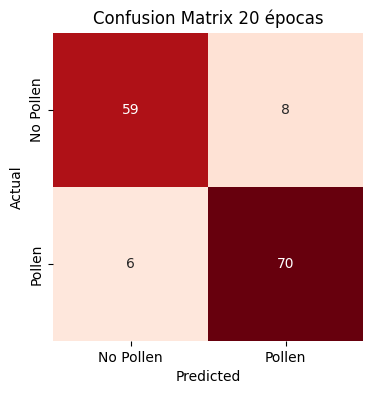



Avaliando modelo com checkpoint ResnetV2/cp-0030.ckpt correspondente a época 30
5/5 [==============================] - 2s 89ms/step - loss: 0.2905 - acc: 0.9091
Restored model, accuracy: 0.9090909361839294
Restored model, loss: 0.29052308201789856

5/5 [==============================] - 1s 83ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        67
           1       0.93      0.89      0.91        76

    accuracy                           0.91       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.91      0.91      0.91       143



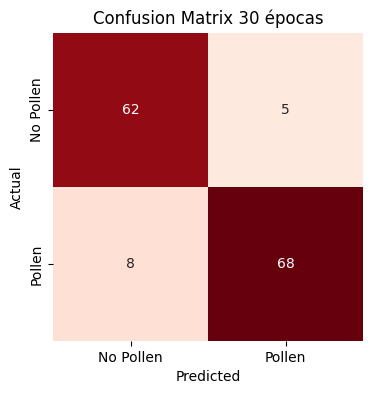



Avaliando modelo com checkpoint ResnetV2/cp-0040.ckpt correspondente a época 40
5/5 [==============================] - 2s 83ms/step - loss: 0.3134 - acc: 0.9231
Restored model, accuracy: 0.9230769276618958
Restored model, loss: 0.31343427300453186

5/5 [==============================] - 1s 80ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92        67
           1       0.92      0.93      0.93        76

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



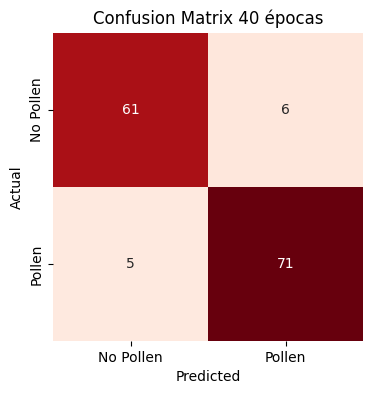



Avaliando modelo com checkpoint ResnetV2/cp-0050.ckpt correspondente a época 50


5/5 [==============================] - 3s 92ms/step - loss: 0.1678 - acc: 0.9510
Restored model, accuracy: 0.9510489702224731
Restored model, loss: 0.16776439547538757

5/5 [==============================] - 2s 99ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        67
           1       0.96      0.95      0.95        76

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



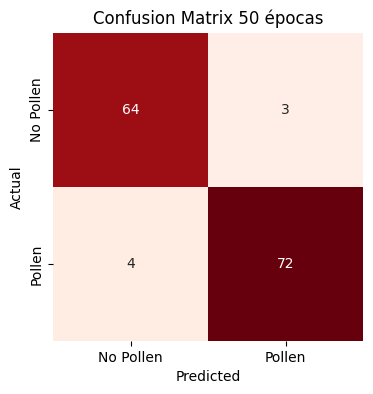



Avaliando modelo com checkpoint ResnetV2/cp-0060.ckpt correspondente a época 60
5/5 [==============================] - 2s 87ms/step - loss: 0.2610 - acc: 0.9371
Restored model, accuracy: 0.9370629191398621
Restored model, loss: 0.26100894808769226

5/5 [==============================] - 1s 82ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93        67
           1       0.91      0.97      0.94        76

    accuracy                           0.94       143
   macro avg       0.94      0.93      0.94       143
weighted avg       0.94      0.94      0.94       143



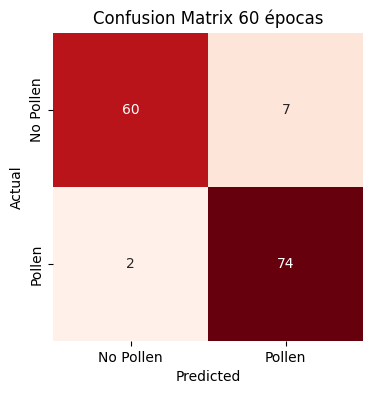



time: 56.3 s (started: 2024-01-15 18:45:33 +00:00)


In [31]:
epoca = 10
for i in range(6):
  cp = "ResnetV2/cp-00"+str(epoca)+".ckpt"
  print("Avaliando modelo com checkpoint " + cp + " correspondente a época " + str(epoca))
  avaliacao_modelo = create_model()
  # Load the previously saved weights
  avaliacao_modelo.load_weights(cp)

  # Re-evaluate the model
  loss, acc = avaliacao_modelo.evaluate(X_test, Y_test)
  print("Restored model, accuracy: " + str(acc) )
  print("Restored model, loss: " + str(loss) + "\n")

  metricas(avaliacao_modelo, epoca)

  epoca += 10

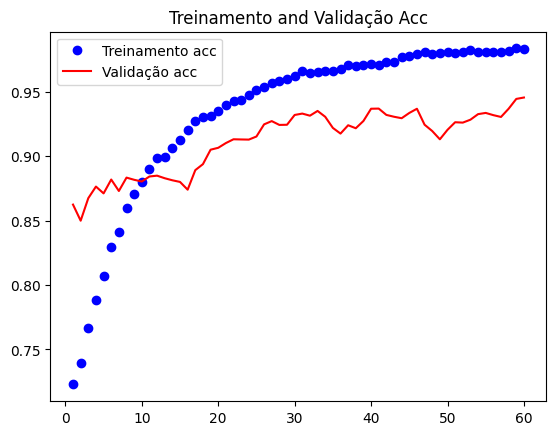

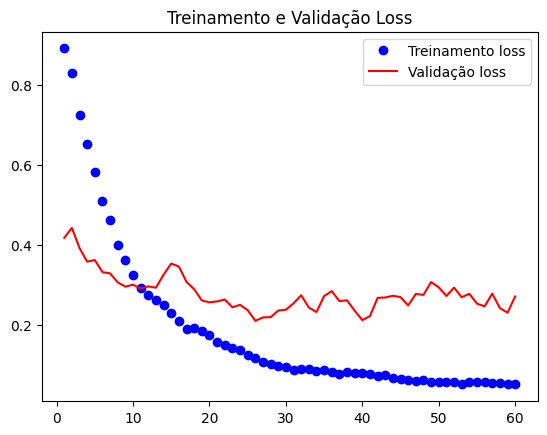



time: 445 ms (started: 2024-01-15 18:47:02 +00:00)


In [32]:
imprime_graficos(history)